<a href="https://colab.research.google.com/github/ZyLiao-0011/NX414/blob/main/task_driven_multiple_models-lzy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/nx414')
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np

### Load the data

In [3]:
path_to_data = '/content/drive/MyDrive/nx414' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [4]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


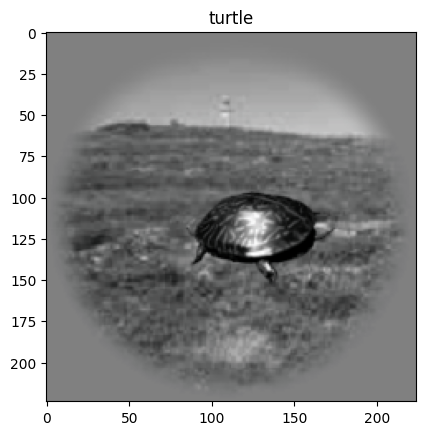

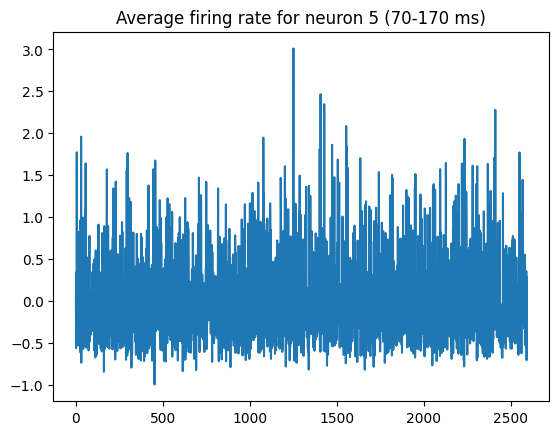

In [5]:
stim_idx = 5

visualize_img(stimulus_train, objects_train, stim_idx)

neuron_idx = 5

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:, neuron_idx])

In [6]:
y_train = spikes_train
y_val = spikes_val

## Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [7]:
import torch
from torch import nn
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score
import gc
import pickle

In [8]:
# Check PyTorch version
print(f"PyTorch version: {torch.__version__}")

# Check if CUDA is available
if torch.cuda.is_available():
    print(f"CUDA available: Yes")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA available: No")


PyTorch version: 2.6.0+cu124
CUDA available: Yes
CUDA version: 12.4
Number of CUDA devices: 1
Current CUDA device: 0
CUDA device name: NVIDIA L4


In [9]:
class FeatureExtractor(nn.Module):
    def __init__(self, model, layers):
        super(FeatureExtractor, self).__init__()
        self.model = model
        self.layers = layers
        self._features = {layer: torch.empty(0) for layer in layers}

        for layer_id in layers:
            layer = dict([*self.model.named_modules()])[layer_id]
            layer.register_forward_hook(self.get_hook(layer_id))

    def get_hook(self, layer_id):
        def hook(module, input, output):
            self._features[layer_id] = output
        return hook

    def forward(self, x):
        self.model(x)
        return [self._features[layer_id] for layer_id in self.layers]

### 2.1 initialize pretrained resnet or random resnet

In [10]:
# Convert HxWxC numpy images to CxHxW torch tensors
def preprocess_images(images):
    # Images are already normalized in the dataset
    # Convert to torch tensor and adjust dimensions
    images_tensor = torch.tensor(images, dtype=torch.float32)
    # Our images are already in the format [batch, channels, height, width]
    return images_tensor

In [11]:
def extract_features(model, stimulus, batch_size=128):
    # Create feature extractor
    extractor = FeatureExtractor(model, layers_to_extract)
    extractor.to(device)
    extractor.eval()

    results = {}

    # Process one layer at a time
    for layer_name in layers_to_extract:
        print(f"\nProcessing layer: {layer_name}")

        # Create DataLoader
        dataset = TensorDataset(preprocess_images(stimulus))
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        # Collect activations
        layer_activations = []

        with torch.no_grad():
            for batch in tqdm(dataloader, desc=f"Extracting {layer_name}"):
                batch = batch[0].to(device)
                # Call the entire model to get all activations
                activations = extractor(batch)
                # Find the index of the current layer
                layer_idx = layers_to_extract.index(layer_name)
                # Get activations for the current layer
                layer_act = activations[layer_idx].cpu().numpy()

                # Flatten
                if len(layer_act.shape) > 2:
                    if layer_name == 'avgpool':
                        layer_act = layer_act.reshape(layer_act.shape[0], -1)
                    else:
                        layer_act = layer_act.reshape(layer_act.shape[0], -1)

                layer_activations.append(layer_act)

        # Combine batches
        layer_act = np.vstack(layer_activations)

        # Store original features
        results[layer_name] = {
            'features': layer_act
        }

        # ===============
        # clean up memory
        del layer_activations, layer_act
        gc.collect()
        torch.cuda.empty_cache()

    # Clean up extractor
    del extractor
    gc.collect()
    torch.cuda.empty_cache()

    return results

In [12]:
def apply_pca_to_features(train_features, val_features, n_components=1000):
    train_pcs = {}
    val_pcs = {}

    for layer_name in layers_to_extract:
        X_train = train_features[layer_name]['features']
        X_val = val_features[layer_name]['features']

        # If n_components is greater than or equal to the feature dimensions, skip PCA
        if n_components >= X_train.shape[1]:
            print(f"Layer {layer_name}: Skipping PCA as n_components ({n_components}) >= feature dimensions ({X_train.shape[1]})")
            train_pcs[layer_name] = {
                'pcs': X_train,
                'scaler': None,
                'pca': None
            }
            val_pcs[layer_name] = {
                'pcs': X_val
            }
            continue

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)  # 使用相同的scaler

        n_comp = min(n_components, X_train.shape[0], X_train.shape[1])
        pca = PCA(n_components=n_comp)
        train_pcs[layer_name] = {
            'pcs': pca.fit_transform(X_train_scaled),
            'scaler': scaler,
            'pca': pca
        }

        val_pcs[layer_name] = {
            'pcs': pca.transform(X_val_scaled)
        }

        print(f"Layer {layer_name}: {n_comp} components, {sum(pca.explained_variance_ratio_):.4f} variance explained")

    return train_pcs, val_pcs

In [13]:
need_to_extract_pca = "True"

# What model you want to use?
# mobilenet, vgg16, alexnet, densenet, resnet18, resnet50, vit or random for unpretrained model
my_model = "resnet18"

In [14]:
# =============================
# Model Selection Block (MobileNetV2, VGG16, AlexNet, DenseNet121, ResNet18, ViT)
# =============================
from torchvision.models import (
    mobilenet_v2, vgg16, alexnet, densenet121,
    resnet18, vit_b_16,resnet50
)

device = "cuda" if torch.cuda.is_available() else "cpu"

if my_model == "mobilenet":
    print("Using MobileNetV2 pretrained model")
    pretrained_model = mobilenet_v2(pretrained=True)
    pretrained_model.to(device)
    pretrained_model.eval()

    layers_to_extract = [
        'features.0',
        'features.3',
        'features.6',
        'features.10',
        'features.14',
        'features.18',
    ]

elif my_model == "vgg16":
    print("Using VGG16 pretrained model")
    pretrained_model = vgg16(pretrained=True)
    pretrained_model.to(device)
    pretrained_model.eval()

    layers_to_extract = [
        'features.4',
        'features.9',
        'features.16',  # conv3_3
        'features.23',  # conv4_3
        'features.30',  # conv5_3
    ]

elif my_model == "alexnet":
    print("Using AlexNet pretrained model")
    pretrained_model = alexnet(pretrained=True)
    pretrained_model.to(device)
    pretrained_model.eval()

    layers_to_extract = [
        'features.0',   # conv1
        'features.2',
        'features.5',
        'features.12'
        #'features.3',   # conv2
        #'features.6',   # conv3
        #'features.8',   # conv4
        #'features.10',  # conv5

    ]

elif my_model == "densenet":
    print("Using DenseNet121 pretrained model")
    pretrained_model = densenet121(pretrained=True)
    pretrained_model.to(device)
    pretrained_model.eval()

    layers_to_extract = [
        'features.conv0',
        'features.denseblock1',
        'features.denseblock2',
        'features.denseblock3',
        'features.denseblock4',
    ]

elif my_model == "resnet18":
    print("Using ResNet18 pretrained model")
    pretrained_model = resnet18(pretrained=True)
    pretrained_model.to(device)
    pretrained_model.eval()

    layers_to_extract = [
        'conv1',
        'layer1',
        'layer2',
        'layer3',
        'layer4',
    ]

elif my_model == "resnet50":
    print("Using ResNet50 pretrained model")
    pretrained_model = resnet50(pretrained=True)
    pretrained_model.to(device)
    pretrained_model.eval()

    layers_to_extract = [
        'conv1',
        'layer1',
        'layer2',
        'layer3',
        'layer4',
    ]

elif my_model == "vit":
    print("Using Vision Transformer (ViT-B/16) pretrained model")
    pretrained_model = vit_b_16(pretrained=True)
    pretrained_model.to(device)
    pretrained_model.eval()

    # ViT has a flat structure, so just one key representation layer
    layers_to_extract = [
        'encoder.ln',
        'heads',
    ]

else:
    raise ValueError("Unsupported model type. Choose from: 'pretrained', 'vgg16', 'alexnet', 'densenet', 'resnet', 'vit'")


Using ResNet18 pretrained model


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
need_to_extract_pca,my_model

('True', 'resnet18')

In [ ]:
for name, t in pretrained_model.named_modules():
    print(t)

In [17]:
torch.cuda.empty_cache()

In [18]:
if need_to_extract_pca:
    #if my_model == "pretrained":
    if my_model != "random":
        print("Extracting features from pre-trained model...")
        #pretrained_features_train = extract_features(pretrained_model, stimulus_train)
        #pretrained_features_val = extract_features(pretrained_model, stimulus_val)
        pretrained_features_train = extract_features(pretrained_model, stimulus_train, batch_size=64)
        pretrained_features_val = extract_features(pretrained_model, stimulus_val, batch_size=64)
    else:
        print("Extracting features from randomly initialized model...")
        random_features_train = extract_features(random_model, stimulus_train)
        random_features_val = extract_features(random_model, stimulus_val)
else:
    print("No need to extract features")

Extracting features from pre-trained model...

Processing layer: conv1


Extracting conv1: 100%|██████████| 41/41 [00:08<00:00,  5.06it/s]



Processing layer: layer1


Extracting layer1: 100%|██████████| 41/41 [00:03<00:00, 13.40it/s]



Processing layer: layer2


Extracting layer2: 100%|██████████| 41/41 [00:02<00:00, 17.48it/s]



Processing layer: layer3


Extracting layer3: 100%|██████████| 41/41 [00:01<00:00, 26.82it/s]



Processing layer: layer4


Extracting layer4: 100%|██████████| 41/41 [00:01<00:00, 28.03it/s]



Processing layer: conv1


Extracting conv1: 100%|██████████| 5/5 [00:00<00:00,  8.60it/s]



Processing layer: layer1


Extracting layer1: 100%|██████████| 5/5 [00:00<00:00, 24.94it/s]



Processing layer: layer2


Extracting layer2: 100%|██████████| 5/5 [00:00<00:00, 27.85it/s]



Processing layer: layer3


Extracting layer3: 100%|██████████| 5/5 [00:00<00:00, 29.73it/s]



Processing layer: layer4


Extracting layer4: 100%|██████████| 5/5 [00:00<00:00, 30.90it/s]


In [19]:
if need_to_extract_pca == "True":
    print(f"Extracting PCA from {my_model} model...")
    #if my_model == "pretrained":
    if my_model != "random":
        pretrained_pcs_train, pretrained_pcs_val = apply_pca_to_features(
            pretrained_features_train,
            pretrained_features_val,
            n_components=1000
        )
    else:
        random_pcs_train, random_pcs_val = apply_pca_to_features(
            random_features_train,
            random_features_val,
            n_components=1000
        )
else:
    print("No need to extract PCA from features")

Extracting PCA from resnet18 model...
Layer conv1: 1000 components, 0.8778 variance explained
Layer layer1: 1000 components, 0.7473 variance explained
Layer layer2: 1000 components, 0.7195 variance explained
Layer layer3: 1000 components, 0.7742 variance explained
Layer layer4: 1000 components, 0.8790 variance explained


In [131]:
if need_to_extract_pca == "True":
    #if my_model == "pretrained":
    if my_model != "random":
        print("Saving pretrained PCA...")
        with open('pretrained_pcs.pkl', 'wb') as f:
            pickle.dump((pretrained_pcs_train, pretrained_pcs_val), f)
    else:
        print("Saving random PCA...")
        with open('random_pcs.pkl', 'wb') as f:
            pickle.dump((random_pcs_train, random_pcs_val), f)
else:
    #if my_model == "pretrained":
    if my_model != "random":
        print("Loading pretrained PCA...")
        with open('pretrained_pcs.pkl', 'rb') as f:
            pretrained_pcs_train, pretrained_pcs_val = pickle.load(f)
    else:
        print("Loading random PCA...")
        with open('random_pcs.pkl', 'rb') as f:
            random_pcs_train, random_pcs_val = pickle.load(f)

print("===============")
print("Completed")

Saving pretrained PCA...


KeyboardInterrupt: 

### 2.2 Now train regressors

- read in train_pc
- train regressor
- test
- return a sample (for visualization purpose)
- return metrics

What are these metrics returned?
- 1. a vector of size n, correlations for all n neurons
- 2. a vector of size n, exp_variances for all nn eurons
- for these neurons, we obtain the average
    - 3. a scalar of mean correlation
    - 4. a scalar of mean variance

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.metrics import explained_variance_score
from tqdm import tqdm

In [21]:
from sklearn.model_selection import KFold


def find_best_alpha_ridge(X, y, candidate_alphas=None, n_splits=5, scoring='explained_variance'):
    """
    Perform k-fold cross-validation to find the best alpha for Ridge regression.

    Parameters:
        X (np.ndarray): Input features of shape (n_samples, n_features)
        y (np.ndarray): Target values of shape (n_samples, n_targets)
        candidate_alphas (list): List of alpha values to try
        n_splits (int): Number of cross-validation folds
        scoring (str): Metric to use ('explained_variance' or 'correlation')

    Returns:
        float: Best alpha value
    """
    if candidate_alphas is None:
        candidate_alphas = np.logspace(-2,5,5)

    best_alpha = None
    best_score = -np.inf

    for alpha in candidate_alphas:
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        fold_scores = []

        for train_idx, val_idx in kf.split(X):
            X_tr, X_val = X[train_idx], X[val_idx]
            y_tr, y_val_cv = y[train_idx], y[val_idx]

            model = Ridge(alpha=alpha)
            model.fit(X_tr, y_tr)
            preds = model.predict(X_val)

            if scoring == 'explained_variance':
                score = np.mean([
                    explained_variance_score(y_val_cv[:, n], preds[:, n])
                    for n in range(y.shape[1])
                ])
            elif scoring == 'correlation':
                score = np.mean([
                    np.corrcoef(preds[:, n], y_val_cv[:, n])[0, 1]
                    for n in range(y.shape[1])
                ])
            else:
                raise ValueError("Invalid scoring. Use 'explained_variance' or 'correlation'.")

            fold_scores.append(score)

        avg_score = np.mean(fold_scores)
        print(f"Alpha {alpha:.1e} -> CV {scoring}: {avg_score:.4f}")

        if avg_score > best_score:
            best_score = avg_score
            best_alpha = alpha

    print(f"✅ Best alpha: {best_alpha:.1e} with CV {scoring}: {best_score:.4f}")
    return best_alpha

In [22]:
def predict_neural_activity(layer_pcs_train, layer_pcs_val, y_train, y_val, sample_to_plot=0):
    layer_metrics = {}
    sample_predictions = {}

    for layer_name in layers_to_extract:
        print(f"Predicting neural activity using {layer_name}")
        X_train_pcs = layer_pcs_train[layer_name]['pcs']
        X_val_pcs = layer_pcs_val[layer_name]['pcs']


        if X_train_pcs.shape[1] != X_val_pcs.shape[1]:
            print(f"Warning: Feature mismatch for {layer_name}. Training: {X_train_pcs.shape[1]}, Validation: {X_val_pcs.shape[1]}")
            min_components = min(X_train_pcs.shape[1], X_val_pcs.shape[1])
            X_train_pcs = X_train_pcs[:, :min_components]
            X_val_pcs = X_val_pcs[:, :min_components]
            print(f"Using {min_components} components for both sets")

        correlations = []
        exp_variances = []
        sample_neuron_predictions = []  # Store predictions for all neurons for a specific sample

        #lr = LinearRegression()
        #lr = Ridge(alpha=3e5)
        best_alpha = find_best_alpha_ridge(X_train_pcs, y_train, candidate_alphas=np.logspace(-2,5,5), n_splits=5, scoring='explained_variance')
        lr = Ridge(alpha=best_alpha)
        lr.fit(X_train_pcs, y_train)

        y_pred = lr.predict(X_val_pcs)
        y_true = y_val

            # Calculate correlation and explained variance
        for neuron in tqdm(range(y_train.shape[1]), desc=f"Training models for {layer_name}"):
            correlation = np.corrcoef(y_pred[:,neuron], y_true[:,neuron])[0, 1]
            exp_var = explained_variance_score(y_true[:,neuron], y_pred[:,neuron])

            correlations.append(correlation)
            exp_variances.append(exp_var)

            # Save prediction for the specific sample
            sample_neuron_predictions.append(y_pred[sample_to_plot,neuron])

        layer_metrics[layer_name] = {
            'correlations': correlations,
            'exp_variances': exp_variances,
            'mean_correlation': np.mean(correlations),
            'mean_exp_variance': np.mean(exp_variances)
        }

        sample_predictions[layer_name] = np.array(sample_neuron_predictions)

        print(f"Mean correlation for {layer_name}: {np.mean(correlations):.4f}")
        print(f"Mean explained variance for {layer_name}: {np.mean(exp_variances):.4f}")


    # PLOT a single case just to visualize... not that meaningful tho

    # Plot predictions for all neurons from each layer for a specific sample
    plt.figure(figsize=(14, 7))

    """# Plot true values
    neurons = np.arange(y_val.shape[1])
    plt.plot(neurons, y_val[sample_to_plot], 'ko-', label='True Activity', linewidth=2)

    # Plot predictions from each layer
    colors = plt.cm.tab10(np.linspace(0, 1, len(layers_to_extract)))
    for i, layer_name in enumerate(layers_to_extract):
        plt.plot(neurons, sample_predictions[layer_name], 'o-',
                 color=colors[i], label=f'{layer_name} Prediction',
                 alpha=0.8)

    plt.title(f'Neural Activity Predictions for Sample {sample_to_plot}')
    plt.xlabel('Neuron Number')
    plt.ylabel('Neural Activity')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('all_layer_predictions.png')
    plt.show()"""
    plt.figure(figsize=(14, 7))
    neurons = np.arange(y_val.shape[1])
    plt.plot(neurons, y_val[sample_to_plot], 'ko-', label='True Activity', linewidth=2)

    colors = plt.cm.tab10(np.linspace(0, 1, len(layers_to_extract)))
    for i, layer_name in enumerate(layers_to_extract):
        plt.plot(neurons, sample_predictions[layer_name], 'o-', color=colors[i], label=f'{layer_name} Prediction', alpha=0.8)

    plt.title(f'Neural Activity Predictions for Sample {sample_to_plot}')
    plt.xlabel('Neuron Number')
    plt.ylabel('Neural Activity')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('all_layer_predictions.png')
    plt.show()

    return layer_metrics


In [29]:
def predict_neural_activity_layerwise(layer_pcs_train, layer_pcs_val, y_train, y_val, sample_to_plot=0):
    layer_metrics = {}
    sample_predictions = {}

    for layer_name in layers_to_extract:
        print(f"\nPredicting neural activity using {layer_name}")
        X_train_pcs = layer_pcs_train[layer_name]['pcs']
        X_val_pcs = layer_pcs_val[layer_name]['pcs']

        if X_train_pcs.shape[1] != X_val_pcs.shape[1]:
            print(f"Warning: Feature mismatch for {layer_name}. Training: {X_train_pcs.shape[1]}, Validation: {X_val_pcs.shape[1]}")
            min_components = min(X_train_pcs.shape[1], X_val_pcs.shape[1])
            X_train_pcs = X_train_pcs[:, :min_components]
            X_val_pcs = X_val_pcs[:, :min_components]
            print(f"Using {min_components} components for both sets")

        correlations = []
        exp_variances = []
        sample_neuron_predictions = []

        """for neuron in tqdm(range(y_train.shape[1]), desc=f"Training models for {layer_name}"):
            lr = LinearRegression()
            lr.fit(X_train_pcs, y_train[:, neuron])
            y_pred = lr.predict(X_val_pcs)
            y_true = y_val[:, neuron]

            correlation = np.corrcoef(y_pred, y_true)[0, 1]
            exp_var = explained_variance_score(y_true, y_pred)

            correlations.append(correlation)
            exp_variances.append(exp_var)
            sample_neuron_predictions.append(y_pred[sample_to_plot])
            """

        #lr = LinearRegression()
        best_alpha = find_best_alpha_ridge(X_train_pcs, y_train, candidate_alphas=np.logspace(-2,5,5), n_splits=5, scoring='explained_variance')
        lr = Ridge(alpha=best_alpha)
        lr.fit(X_train_pcs, y_train)

        y_pred = lr.predict(X_val_pcs)
        y_true = y_val

        # Calculate correlation and explained variance
        for neuron in tqdm(range(y_train.shape[1]), desc=f"Training models for {layer_name}"):
            correlation = np.corrcoef(y_pred[:,neuron], y_true[:,neuron])[0, 1]
            exp_var = explained_variance_score(y_true[:,neuron], y_pred[:,neuron])

            correlations.append(correlation)
            exp_variances.append(exp_var)

            # Save prediction for the specific sample
            sample_neuron_predictions.append(y_pred[sample_to_plot,neuron])

        layer_metrics[layer_name] = {
            'correlations': correlations,
            'exp_variances': exp_variances,
            'mean_correlation': np.mean(correlations),
            'mean_exp_variance': np.mean(exp_variances)
        }

        sample_predictions[layer_name] = np.array(sample_neuron_predictions)

        print(f"Mean correlation for {layer_name}: {np.mean(correlations):.4f}")
        print(f"Mean explained variance for {layer_name}: {np.mean(exp_variances):.4f}")

        # === Per-layer plot ===
        """plt.figure(figsize=(10, 5))
        neurons = np.arange(y_val.shape[1])
        plt.plot(neurons, y_val[sample_to_plot], 'ko-', label='True Activity', linewidth=2)
        plt.plot(neurons, sample_predictions[layer_name], 'ro-', label='Predicted Activity', alpha=0.8)
        plt.title(f'Neural Activity Prediction - {layer_name} (Sample {sample_to_plot})')
        plt.xlabel('Neuron Number')
        plt.ylabel('Neural Activity')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.savefig(f'prediction_{layer_name.replace(".", "_")}.png')
        plt.show()"""
        plt.figure(figsize=(10, 5))
        neurons = np.arange(y_val.shape[1])
        plt.plot(neurons, y_val[sample_to_plot], 'ko-', label='True Activity', linewidth=2)
        plt.plot(neurons, sample_predictions[layer_name], 'ro-', label='Predicted Activity', alpha=0.8)
        plt.title(f'Neural Activity Prediction - {layer_name} (Sample {sample_to_plot})')
        plt.xlabel('Neuron Number')
        plt.ylabel('Neural Activity')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.savefig(f'prediction_{layer_name.replace(".", "_")}.png')
        plt.show()

    return layer_metrics


In [24]:
def plot_layer_metrics(my_model, layer_metrics, metric='exp_variances'):
    # Calculate mean metrics for each layer
    layers = layers_to_extract

    # Map metric parameter to the actual keys in the metrics dictionaries
    if metric == 'exp_variances' or metric == 'exp_variance':
        mean_key = 'mean_exp_variance'
        dist_key = 'exp_variances'
    elif metric == 'correlation':
        mean_key = 'mean_correlation'
        dist_key = 'correlations'
    else:
        mean_key = f'mean_{metric}'
        dist_key = metric

    # Prepare x-axis with layer names
    x = np.arange(len(layers))
    width = 0.35

    # Create plot
    plt.figure(figsize=(12, 6))

    # Get means for the model type
    model_means = [layer_metrics[layer][mean_key] for layer in layers]

    # Plot based on model type
    #if my_model == "pretrained":
    if my_model != "random":
        plt.bar(x, model_means, width, label='Pre-trained')
    elif my_model == "random":
        plt.bar(x, model_means, width, label='Random')

    plt.xlabel('Network Layer')
    plt.ylabel('Mean ' + ('Correlation' if 'correlation' in metric else 'Explained Variance'))
    plt.title('Performance Across Layers')
    plt.xticks(x, layers, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

Predicting with pre-trained model features...
Predicting neural activity using conv1
Alpha 1.0e-02 -> CV explained_variance: -2.3721
Alpha 5.6e-01 -> CV explained_variance: -2.3720
Alpha 3.2e+01 -> CV explained_variance: -2.3679
Alpha 1.8e+03 -> CV explained_variance: -2.1559
Alpha 1.0e+05 -> CV explained_variance: -0.2630
✅ Best alpha: 1.0e+05 with CV explained_variance: -0.2630


Training models for conv1: 100%|██████████| 168/168 [00:00<00:00, 1600.91it/s]


Mean correlation for conv1: 0.2671
Mean explained variance for conv1: 0.0531
Predicting neural activity using layer1
Alpha 1.0e-02 -> CV explained_variance: -0.6931
Alpha 5.6e-01 -> CV explained_variance: -0.6931
Alpha 3.2e+01 -> CV explained_variance: -0.6912
Alpha 1.8e+03 -> CV explained_variance: -0.5956
Alpha 1.0e+05 -> CV explained_variance: 0.1530
✅ Best alpha: 1.0e+05 with CV explained_variance: 0.1530


Training models for layer1: 100%|██████████| 168/168 [00:00<00:00, 1245.92it/s]


Mean correlation for layer1: 0.4779
Mean explained variance for layer1: 0.2406
Predicting neural activity using layer2
Alpha 1.0e-02 -> CV explained_variance: -0.4941
Alpha 5.6e-01 -> CV explained_variance: -0.4940
Alpha 3.2e+01 -> CV explained_variance: -0.4910
Alpha 1.8e+03 -> CV explained_variance: -0.3514
Alpha 1.0e+05 -> CV explained_variance: 0.2497
✅ Best alpha: 1.0e+05 with CV explained_variance: 0.2497


Training models for layer2: 100%|██████████| 168/168 [00:00<00:00, 1638.23it/s]


Mean correlation for layer2: 0.5243
Mean explained variance for layer2: 0.2797
Predicting neural activity using layer3
Alpha 1.0e-02 -> CV explained_variance: -0.4795
Alpha 5.6e-01 -> CV explained_variance: -0.4793
Alpha 3.2e+01 -> CV explained_variance: -0.4687
Alpha 1.8e+03 -> CV explained_variance: -0.1300
Alpha 1.0e+05 -> CV explained_variance: 0.3447
✅ Best alpha: 1.0e+05 with CV explained_variance: 0.3447


Training models for layer3: 100%|██████████| 168/168 [00:00<00:00, 1442.27it/s]


Mean correlation for layer3: 0.6073
Mean explained variance for layer3: 0.3675
Predicting neural activity using layer4
Alpha 1.0e-02 -> CV explained_variance: -0.2552
Alpha 5.6e-01 -> CV explained_variance: -0.2551
Alpha 3.2e+01 -> CV explained_variance: -0.2467
Alpha 1.8e+03 -> CV explained_variance: 0.0204
Alpha 1.0e+05 -> CV explained_variance: 0.3337
✅ Best alpha: 1.0e+05 with CV explained_variance: 0.3337


Training models for layer4: 100%|██████████| 168/168 [00:00<00:00, 1311.64it/s]


Mean correlation for layer4: 0.5942
Mean explained variance for layer4: 0.3574


<Figure size 1400x700 with 0 Axes>

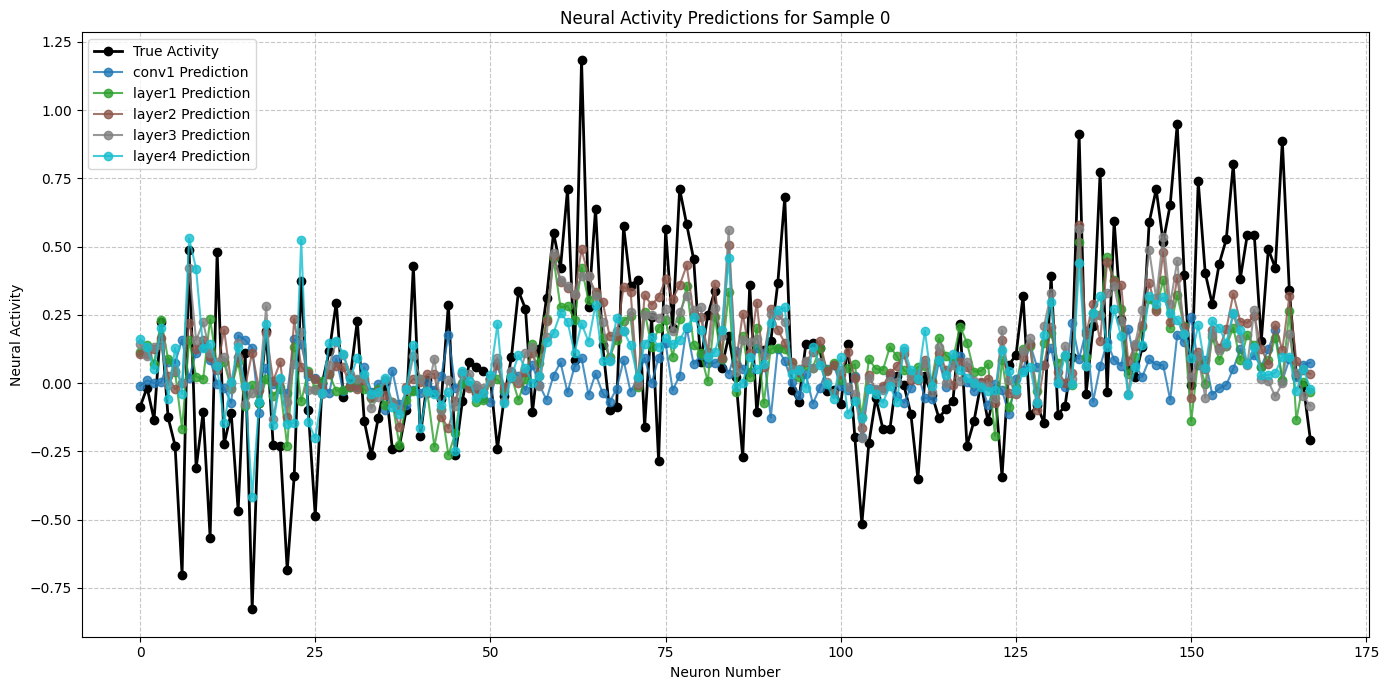

In [25]:
#if my_model == "pretrained":
if my_model != "random":
    print("Predicting with pre-trained model features...")
    layer_metrics = predict_neural_activity(pretrained_pcs_train, pretrained_pcs_val, y_train, y_val)
else:
    print("Predicting with randomly initialized model features...")
    layer_metrics = predict_neural_activity(random_pcs_train, random_pcs_val, y_train, y_val)

In [26]:
import json
import numpy as np

# Suppose your dictionary is called `my_dict`
# Define a custom encoder for NumPy types
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.generic):
            return obj.item()
        return super().default(obj)

with open("/content/drive/MyDrive/nx414/resnet18_best1e5.json", "w") as f:
    json.dump(layer_metrics, f, cls=NumpyEncoder, indent=2)

Predicting with pre-trained model features...

Predicting neural activity using conv1


Training models for conv1: 100%|██████████| 168/168 [00:00<00:00, 1384.46it/s]


Mean correlation for conv1: 0.2793
Mean explained variance for conv1: 0.0781


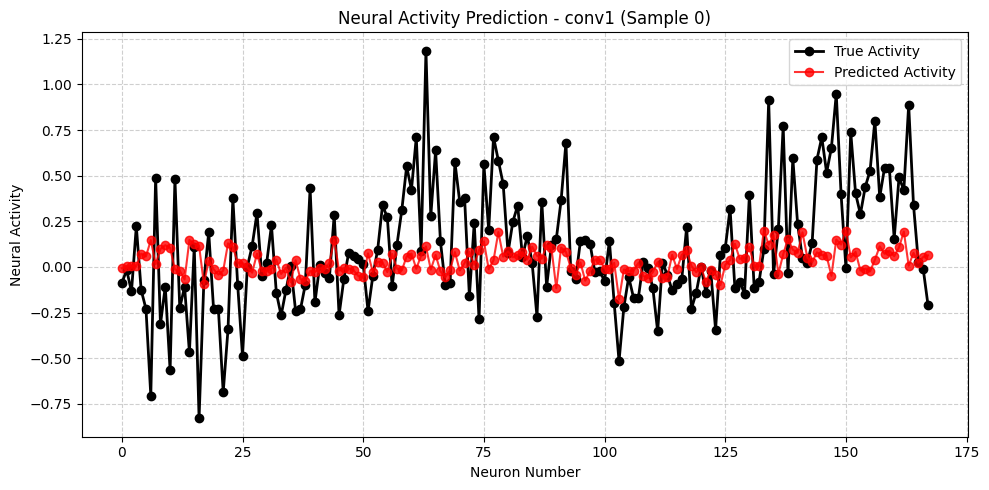


Predicting neural activity using layer1


Training models for layer1: 100%|██████████| 168/168 [00:00<00:00, 1679.69it/s]


Mean correlation for layer1: 0.4771
Mean explained variance for layer1: 0.2287


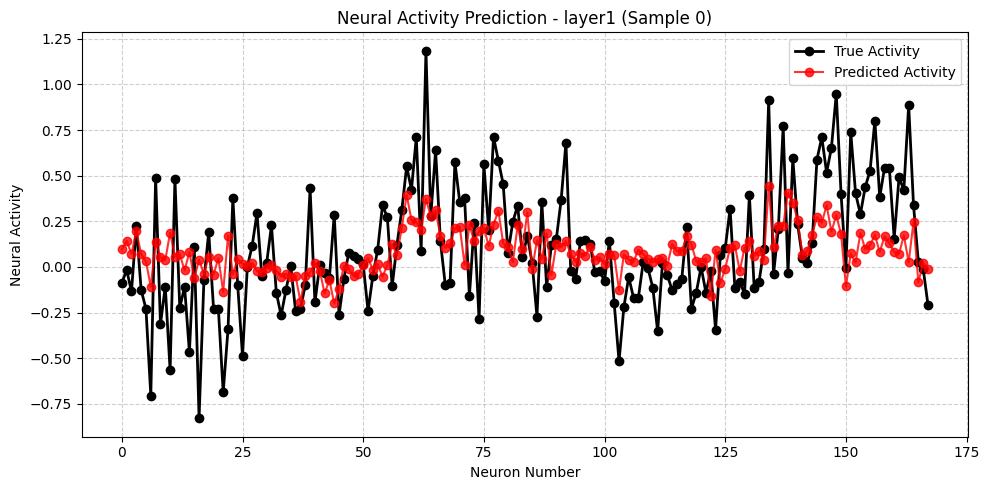


Predicting neural activity using layer2


Training models for layer2: 100%|██████████| 168/168 [00:00<00:00, 1400.64it/s]


Mean correlation for layer2: 0.5116
Mean explained variance for layer2: 0.2404


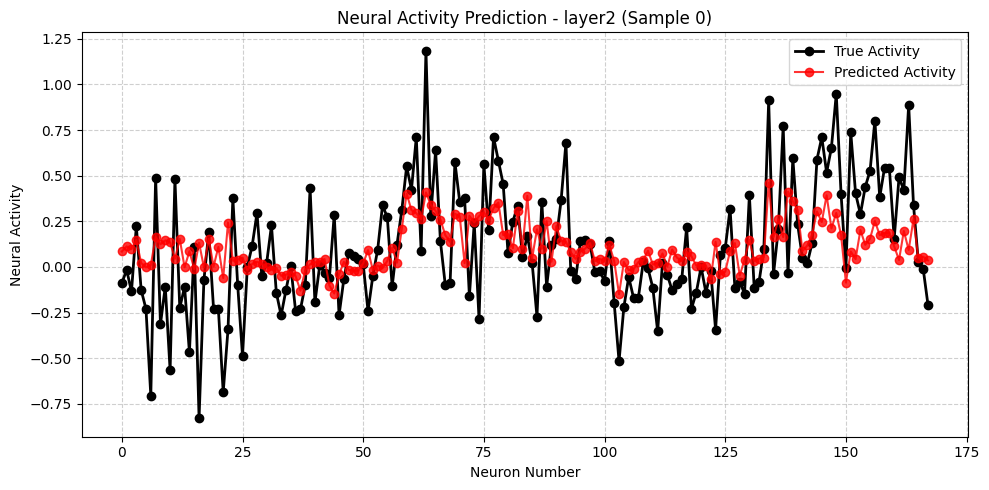


Predicting neural activity using layer3


Training models for layer3: 100%|██████████| 168/168 [00:00<00:00, 1415.39it/s]


Mean correlation for layer3: 0.5884
Mean explained variance for layer3: 0.3099


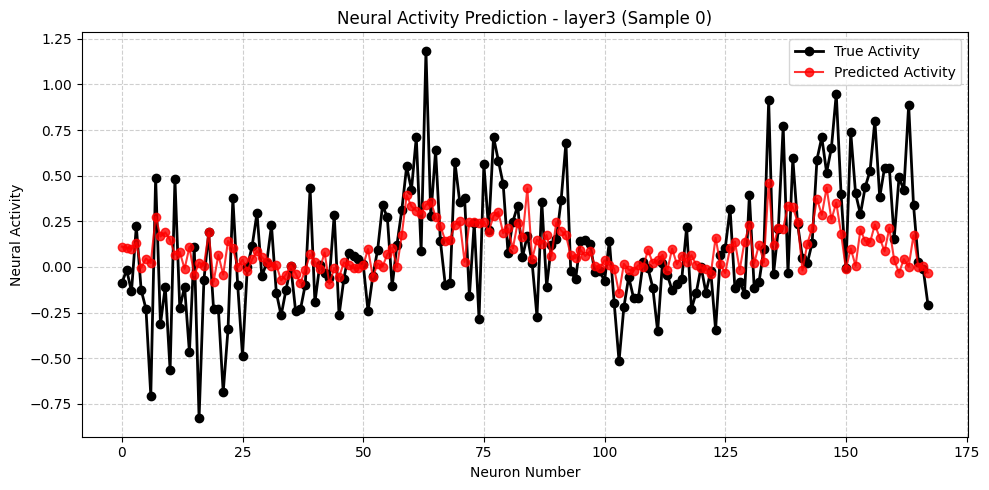


Predicting neural activity using layer4


Training models for layer4: 100%|██████████| 168/168 [00:00<00:00, 1357.96it/s]


Mean correlation for layer4: 0.5802
Mean explained variance for layer4: 0.3168


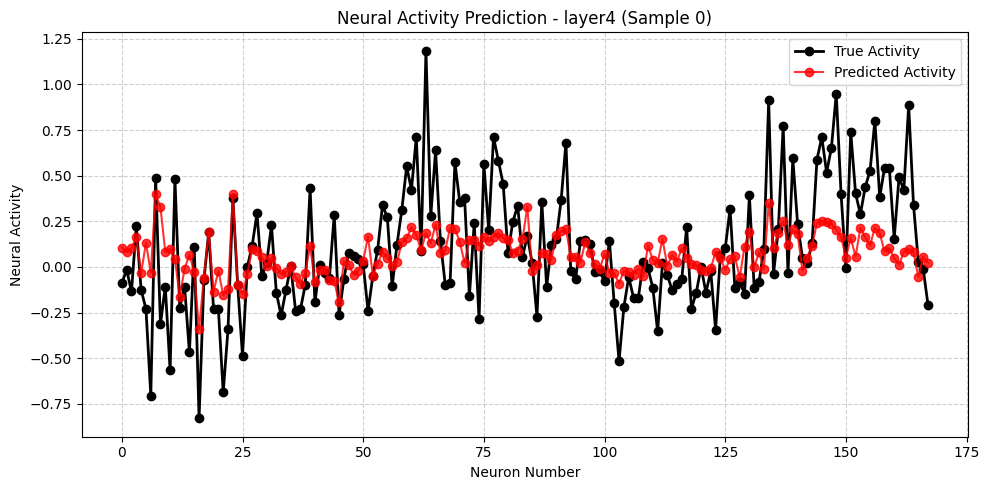

In [30]:
if my_model != "random":
    print("Predicting with pre-trained model features...")
    layer_metrics = predict_neural_activity_layerwise(pretrained_pcs_train, pretrained_pcs_val, y_train, y_val)

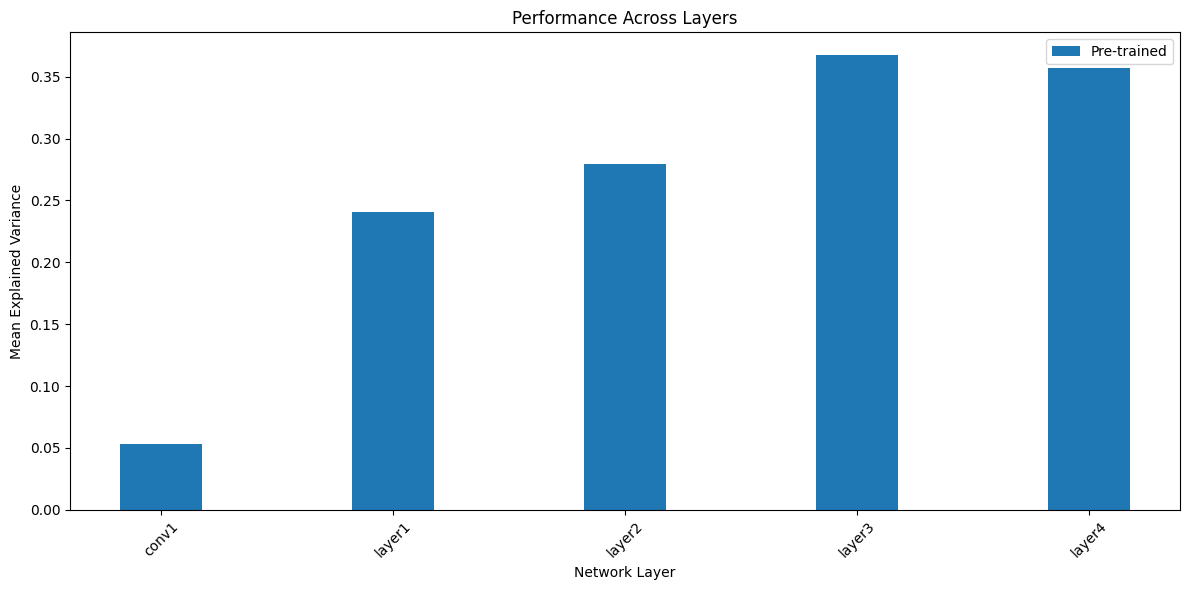

In [27]:
plot_layer_metrics(my_model, layer_metrics=layer_metrics, metric='exp_variances')

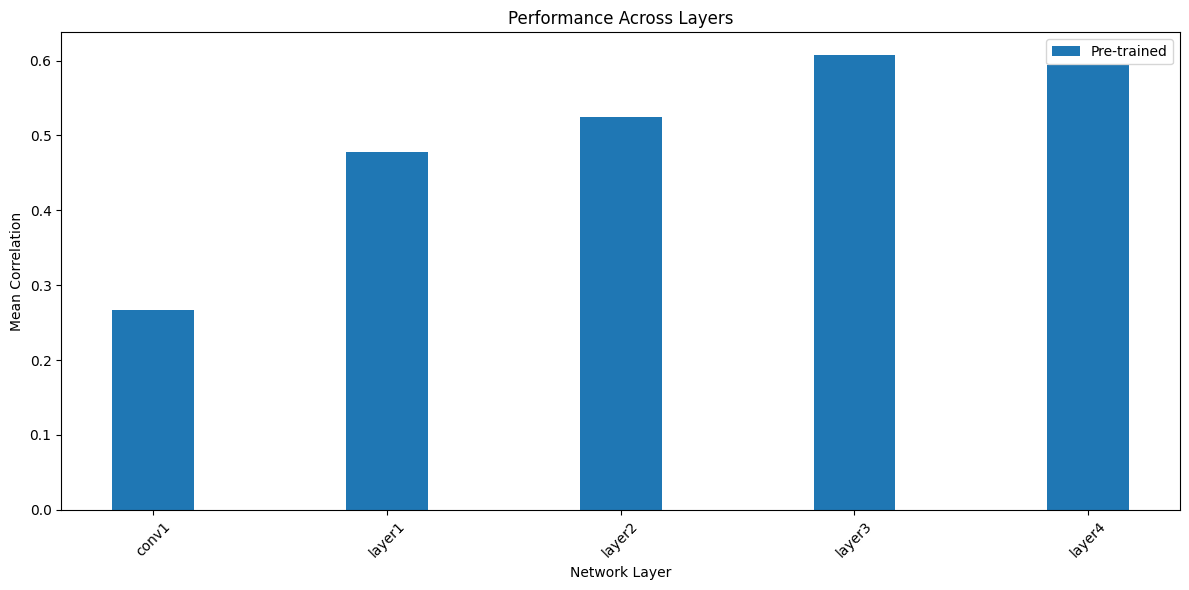

In [28]:
plot_layer_metrics(my_model, layer_metrics=layer_metrics, metric='correlation')

In [95]:
layer_metrics

{'features.4': {'correlations': [np.float64(0.21479934682908516),
   np.float64(0.4472485817297102),
   np.float64(0.27628391869674335),
   np.float64(0.5404130254381895),
   np.float64(0.11941050477217449),
   np.float64(0.13158211298165934),
   np.float64(0.3049256250863389),
   np.float64(0.40070367991414996),
   np.float64(0.380527132059377),
   np.float64(0.35438931738017476),
   np.float64(0.47804230666927716),
   np.float64(0.18014699878197815),
   np.float64(0.42117434337594933),
   np.float64(0.1354733859182272),
   np.float64(0.21559260932672836),
   np.float64(0.17620133120153514),
   np.float64(0.3558185623398371),
   np.float64(0.31636664900415495),
   np.float64(0.38107483644039997),
   np.float64(0.35650528558578176),
   np.float64(0.3088003922514738),
   np.float64(0.19420940882691948),
   np.float64(0.3526101008108944),
   np.float64(0.49409210842598866),
   np.float64(0.1494681261100443),
   np.float64(0.22825154076958573),
   np.float64(0.18654603705744255),
   np.fl